### **Objective:** 

The objective of this project is to segment the customers of a retail company based on their purchasing behaviour.

### **Data analysis process:**

Analysis will be done as follows.

1. Understanding data
2. Data cleaning (Removing duplicates, treating outiliers and missing values etc.)
3. RFM analysis to segment the customers based on their purchasing behaviour.
4. K-Means clustering.
5. Interpretation of the clusters.

In [1]:
# Load the following libraries.

import numpy as np
import datetime as dt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
!pip install openpyxl
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.1/242.1 kB 5.7 MB/s eta 0:00:00a 0:00:01


In [4]:
# Load the data.

customer_df = pd.read_excel("../input/online-retail-ii-data-set-from-ml-repository/online_retail_II.xlsx")

customer_df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom


In [5]:
# Check the data.

customer_df.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object

In [6]:
# Check the data.

customer_df.describe() 

# There are negative values which indicate returned products.

,Quantity,Price,Customer ID
count,525461.000000,525461.000000,417534.000000
mean,10.337667,4.688834,15360.645478
std,107.424110,146.126914,1680.811316
min,-9600.000000,-53594.360000,12346.000000
25%,1.000000,1.250000,13983.000000
50%,3.000000,2.100000,15311.000000
75%,10.000000,4.210000,16799.000000
max,19152.000000,25111.090000,18287.000000


In [7]:
# Check the data.

customer_df['Country'].value_counts()

# Majority of transcations are from United Kingdom.

United Kingdom          485852
EIRE                      9670
Germany                   8129
France                    5772
Netherlands               2769
Spain                     1278
Switzerland               1187
Portugal                  1101
Belgium                   1054
Channel Islands            906
Sweden                     902
Italy                      731
Australia                  654
Cyprus                     554
Austria                    537
Greece                     517
United Arab Emirates       432
Denmark                    428
Norway                     369
Finland                    354
Unspecified                310
USA                        244
Japan                      224
Poland                     194
Malta                      172
Lithuania                  154
Singapore                  117
RSA                        111
Bahrain                    107
Canada                      77
Hong Kong                   76
Thailand                    76
Israel  

In [8]:
# Check the data for missing values.

customer_df.isnull().sum()

# There are many customers without Customer ID.

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

In [9]:
# Renaming "Customer ID" as "CustomerID".

customer_df = customer_df.rename(columns = {"Customer ID": "CustomerID"})

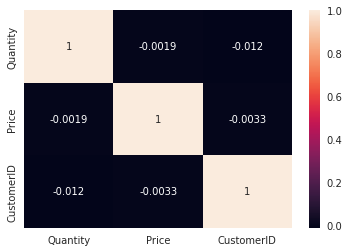

In [10]:
# Checking correlation between variables.

ax = sns.heatmap(customer_df.corr(), annot=True)

# Variables are not correlated with each other.

In [11]:
# Removing negative values.

customer_df = customer_df[(customer_df['Quantity'] > 0) & (customer_df['Price'] > 0)] 

customer_df.describe()

,Quantity,Price,CustomerID
count,511566.000000,511566.000000,407664.000000
mean,11.400150,4.252563,15368.592598
std,86.761177,63.664629,1679.762138
min,1.000000,0.001000,12346.000000
25%,1.000000,1.250000,13997.000000
50%,3.000000,2.100000,15321.000000
75%,10.000000,4.210000,16812.000000
max,19152.000000,25111.090000,18287.000000


In [12]:
# Removing duplicates.

customer_df = customer_df.drop_duplicates()

customer_df.shape

(504731, 8)

### **RFM Analysis**

In [13]:
# Calculating total cost and storing it as "Amount".

customer_df['Amount'] = customer_df['Quantity'] * customer_df['Price']

In [14]:
# Finding out last Invoice date to calculate "Recency".

customer_df.InvoiceDate.max()

Timestamp('2010-12-09 20:01:00')

In [15]:
# Creating RFM dataframe.

pin_date = dt.datetime(2010, 12,10)

rfm = customer_df.groupby('CustomerID').agg({'InvoiceDate': lambda InvoiceDate: (pin_date - InvoiceDate.max()).days,
                                     'Invoice': lambda Invoice: Invoice.nunique(),
                                     'Amount': lambda Amount: Amount.sum()})

rfm.head()

,InvoiceDate,Invoice,Amount
CustomerID,,,
12346.0,164,11,372.86
12347.0,2,2,1323.32
12348.0,73,1,222.16
12349.0,42,3,2671.14
12351.0,10,1,300.93


In [16]:
# Changing column names.

rfm.columns = ['recency', 'frequency', 'monetary']

rfm.head()

,recency,frequency,monetary
CustomerID,,,
12346.0,164,11,372.86
12347.0,2,2,1323.32
12348.0,73,1,222.16
12349.0,42,3,2671.14
12351.0,10,1,300.93


### **Calculating the score**

We need to assign a score from 1 to 5 to recency, frequency and monetary value individually for each customer.

Below is the conversion of columns into rfm scores between 1 to 5.

'5' being the highest and '1' being the least.

* The higher the monetary value, higher is the score i.e.'5'.

* Smaller value of recency indicates recent purchases. So it takes the higher value of 5.

* Frequency is the same as monetary, higher the frequency, higher the score.

In [17]:
rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels = [5, 4, 3, 2, 1])

rfm["frequency_score"] = pd.qcut(rfm['frequency'].rank(method = "first"), 5, labels = [1, 2, 3, 4, 5])

rfm["monetary_score"] = pd.qcut(rfm['monetary'], 5, labels = [1, 2, 3, 4, 5])

rfm['score'] = rfm['recency_score'].astype(int)+rfm['frequency_score'].astype(int)+rfm['monetary_score'].astype(int)

rfm.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,score
CustomerID,,,,,,,
12346.0,164,11,372.86,2,5,2,9
12347.0,2,2,1323.32,5,2,4,11
12348.0,73,1,222.16,2,1,1,4
12349.0,42,3,2671.14,3,3,5,11
12351.0,10,1,300.93,5,1,2,8


### **Identifying best customers using score.**

In [18]:
# Analysing "rfm" dataframe.

rfm.describe()

# Customers with score of 15 are best customers as they have have the highest recency, frequency and monetary score.

,recency,frequency,monetary,score
count,4312.000000,4312.000000,4312.000000,4312.000000
mean,90.172542,4.455705,2040.406712,9.024814
std,96.861457,8.170213,8911.755977,3.584884
min,0.000000,1.000000,2.950000,3.000000
25%,17.000000,1.000000,307.187500,6.000000
50%,52.000000,2.000000,701.615000,9.000000
75%,135.000000,5.000000,1714.932500,12.000000
max,373.000000,205.000000,349164.350000,15.000000


### **Seggregate the levels** 

We are going to seggregate the level of the customer based on the score.

Here we have classified them into 4 levels.

* Active: High revenue generating and frequent buyers.

* Good: Customers whose purchases are fairly frequent and generate moderate revenue.

* Average: Customers who are less active and are not very frequent buyers and generate low revenue.

* Inactive: Customers generating very low revenue and are occasional buyers.

In [19]:
# Definig a function to assign levels to customers.

def rfm_level(score):
    if  ((score >1) and (score < 4)):
        return 'Inactive'
    elif ((score >3) and (score < 8)):
        return 'Average'
    elif ((score > 7) and (score <11)):
        return 'Good'
    else:
        return 'Active'

In [20]:
# Assigning levels to customers.

rfm['level'] = rfm['score'].apply(lambda score : rfm_level(score))

rfm.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,score,level
CustomerID,,,,,,,,
12346.0,164,11,372.86,2,5,2,9,Good
12347.0,2,2,1323.32,5,2,4,11,Active
12348.0,73,1,222.16,2,1,1,4,Average
12349.0,42,3,2671.14,3,3,5,11,Active
12351.0,10,1,300.93,5,1,2,8,Good


<AxesSubplot:xlabel='level', ylabel='count'>

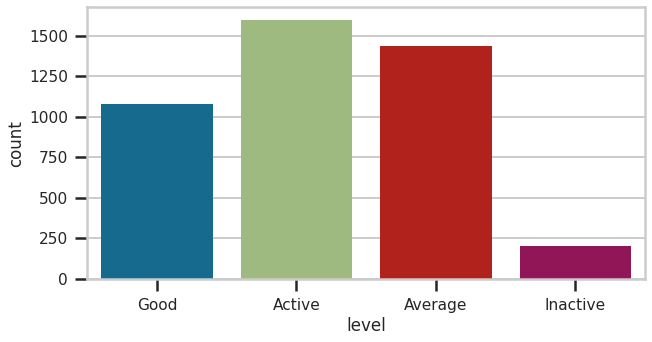

In [21]:
# Visualizing the number of customers in every level.

plt.figure(figsize = (10,5))

sns.set_context("poster", font_scale = 0.7)

sns.countplot(rfm['level'])

# Number of active customers are more in the dataset.

In [22]:
# Analysing customers in each level.

rfm.groupby('level').agg({
    'recency': ['mean', 'min','max'],
    'frequency': ['mean', 'min','max'],
    'monetary': ['mean','min','max','count']
})

recency           frequency              monetary          \
                mean  min  max      mean min  max         mean     min   
level                                                                    
Active     25.954915    0  269  8.958046   1  205  4540.467176  327.68   
Average   150.897490    1  373  1.304045   1    8   351.569124    3.75   
Good       70.223355    0  326  2.627433   1   11   939.920741   10.95   
Inactive  273.346535  176  373  1.000000   1    1   142.490396    2.95   

                           
                max count  
level                      
Active    349164.35  1597  
Average    10953.50  1434  
Good       34095.26  1079  
Inactive     250.26   202

### **Active Customers:**

We can say that 1597 customers bought 4540.46 units by shopping 9 times approximately every 26 days.

They are previliged customers.

Surprise offers can be given on birthdays and anniversary.

### **Good Customers:**

1079 customers have bought 939.92 units by shopping thrice every 70 days

They are loyal customers.

### **Average customers:**

1434 customers have bought approximately 351.56 units by shopping once every 151 days.

Tiered pricing of products can be introduced.

### **Inactive customers:**

202 customers have bought approximately 142.49 units by shopping once every 273 days.

Personalised emails and SMS can be sent to the customers regarding the offers.

More marketing strategies can be introduced to improve the frequency of orders.

In [23]:
# Segmenting customers based on their levels.

active = rfm[rfm['level'] == 'Active']

average = rfm[rfm['level'] == 'Average']

good = rfm[rfm['level'] == 'Good']

inactive = rfm[rfm['level'] == 'Inactive']

In [24]:
# Saving segements in different excel files.

# We are segmenting customers based on their levels, so that it will be easy for the company to send relevent offers and messages to group of customers who belong to the same segment.

active_df = pd.DataFrame()

active_df["customer_id"] = rfm[rfm["level"] == "Active"].index

active_df.to_excel("active_customers.xlsx", sheet_name='Active Customers Index')


average_df = pd.DataFrame()

average_df["customer_id"] = rfm[rfm["level"] == "Average"].index

average_df.to_excel("average_customers.xlsx", sheet_name='Average Customers Index')


good_df = pd.DataFrame()

good_df["customer_id"] = rfm[rfm["level"] == "Good"].index

good_df.to_excel("good_customers.xlsx", sheet_name='Good Customers Index')


inactive_df = pd.DataFrame()

inactive_df["customer_id"] = rfm[rfm["level"] == "Inactive"].index

inactive_df.to_excel("inactive_customers.xlsx", sheet_name='Inactive Customers Index')

### **K-Means clustering**

Applying K-Means method to identify different clusters based on segmentation of customers according to their purchasing behaviour.

Clustering will be done using 3 factors as recency, frequency and monetary values.

### **Outlier treatment**

In [25]:
# Extracting only numeric columns from rfm.

numeric_cols = rfm.select_dtypes(include = 'number')

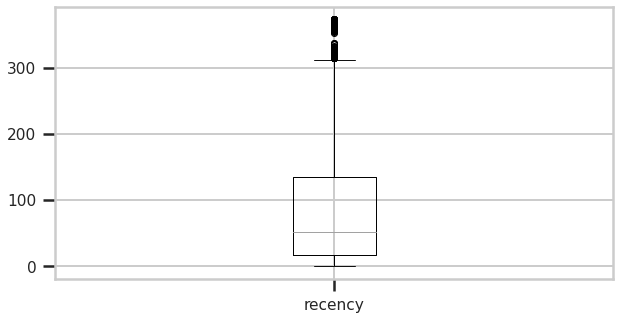

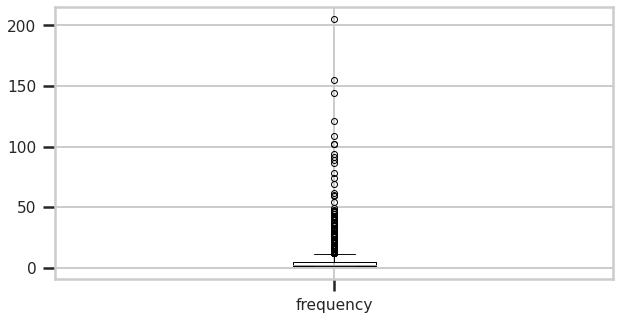

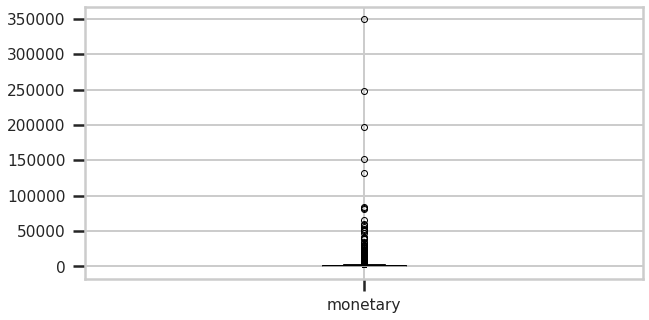

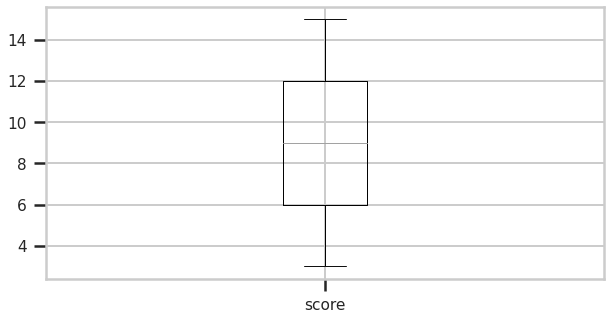

In [26]:
# Plotting boxplots for all continous variables in order to detect outliers.

for column in numeric_cols:
    plt.figure(figsize = (10,5))
    numeric_cols.boxplot([column])
    
# Some variables have outliers. These outliers will be treated in the next step.

In [27]:
# Flooring and capping ouliers.

for col in numeric_cols.columns:
    Q1 = numeric_cols[col].quantile(0.25)
    Q3 = numeric_cols[col].quantile(0.75)
    IQR = Q3 - Q1 
    Lower_cap  = Q1 - 1.5*IQR
    Upper_cap = Q3 + 1.5*IQR
    numeric_cols[col][numeric_cols[col] <= Lower_cap] = Lower_cap
    numeric_cols[col][numeric_cols[col] >= Upper_cap] = Upper_cap

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we l

In [28]:
# Dropping following columns from rfm.

rfm.drop(['recency', 'frequency', 'monetary', 'score'], axis = 1, inplace = True)

In [29]:
# Setting indices.

numeric_cols.reset_index(drop = True, inplace = True)

rfm.reset_index(drop = True, inplace = True)

In [30]:
# Joining df "numeric_cols" and df "rfm".

rfm = pd.concat([rfm, numeric_cols], axis = 1)

rfm

,recency_score,frequency_score,monetary_score,level,recency,frequency,monetary,score
0,2,5,2,Good,164,11,372.86,9
1,5,2,4,Active,2,2,1323.32,11
2,2,1,1,Average,73,1,222.16,4
3,3,3,5,Active,42,3,2671.14,11
4,5,1,2,Good,10,1,300.93,8
...,...,...,...,...,...,...,...,...
4307,4,5,3,Active,17,6,619.37,12
4308,3,2,2,Average,66,1,461.68,7
4309,1,2,2,Average,295,1,427.00,5
4310,2,3,4,Good,111,2,1296.43,9


In [31]:
# Scaling the data before applying K-Means.

rfm1 = rfm[['recency','frequency','monetary']]

scaler = StandardScaler()

scaled = scaler.fit(rfm1)

scaled = scaler.fit_transform(rfm1)

scaled

array([[ 0.81169059,  2.40145147, -0.69739194],
       [-0.93312833, -0.52022163,  0.10369075],
       [-0.16842374, -0.84485198, -0.82440745],
       ...,
       [ 2.2226244 , -0.84485198, -0.65176075],
       [ 0.24085477, -0.52022163,  0.08102686],
       [-0.77157102,  0.12903906,  0.96539869]])

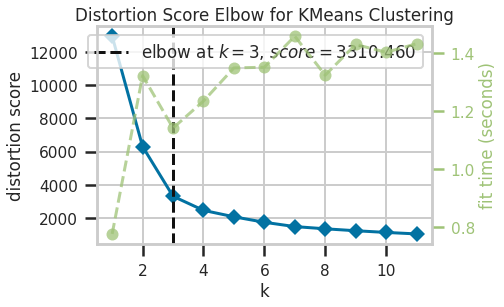

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [32]:
# Finding out number of clusters to be formed using Elbow method.

model = KMeans()

visualizer = KElbowVisualizer(model, k = (1,12))

visualizer.fit(scaled)

visualizer.show()   

# According to Elbow method, number of clusters = 3.

[0 2 0 ... 0 2 2]
 Our cluster centers are as follows
[[-0.64045829  1.54109782  1.56050095]
 [-0.4305411  -0.35288209 -0.37795258]
 [ 1.60819528 -0.6743488  -0.63538154]]


,recency,frequency,monetary
cluster_pred,,,
0,975,975,975
1,2325,2325,2325
2,1012,1012,1012


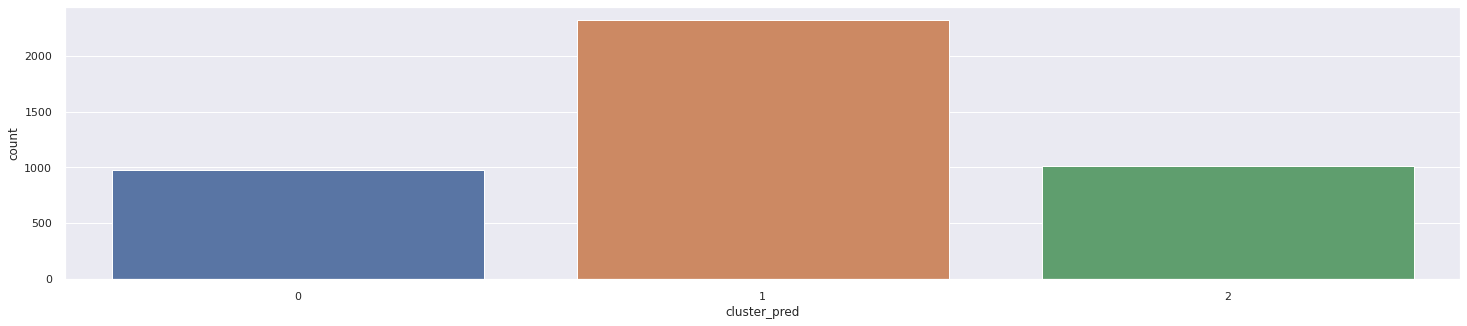

In [33]:
# Applying K-Means.

kmeans_scaled = KMeans(3)

kmeans_scaled.fit(scaled)

identified_clusters = kmeans_scaled.fit_predict(rfm1)

clusters_scaled = rfm1.copy()

clusters_scaled['cluster_pred'] = kmeans_scaled.fit_predict(scaled)

print(identified_clusters)

sns.set(style = "darkgrid")

print(" Our cluster centers are as follows")

print(kmeans_scaled.cluster_centers_)

f, ax = plt.subplots(figsize = (25, 5))

ax = sns.countplot(x = "cluster_pred", data = clusters_scaled)

clusters_scaled.groupby(['cluster_pred']).count()

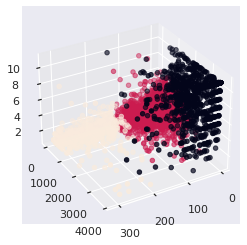

In [34]:
# Visualizing the clusters.

fig = plt.figure()

ax = plt.axes(projection = '3d')

xline = clusters_scaled['recency']

yline = clusters_scaled['frequency']

zline = clusters_scaled['monetary']

ax.scatter3D(xline, zline,yline,c = clusters_scaled['cluster_pred'])

ax.view_init(30, 60)

### **Cluster profiling**

In [35]:
# Analyzing the clusters.

rfm1['cluster'] = clusters_scaled['cluster_pred']

rfm1['level'] = rfm['level']

rfm1.groupby('cluster').agg({
    'recency' : ['mean','min','max'],
    'frequency' : ['mean','min','max'],
    'monetary' : ['mean','min','max','count']
})

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


recency           frequency             monetary                   \
               mean  min  max      mean min max         mean     min      max   
cluster                                                                         
0         29.173333    0  267  8.349744   1  11  3051.780557  372.86  3826.55   
1         48.624086    0  161  2.515699   1   9   752.071613   10.95  3138.04   
2        237.855731  135  312  1.525692   1   8   446.260547    2.95  3826.55   

               
        count  
cluster        
0         975  
1        2325  
2        1012

Cluster 1: Not good customers as they have highest recency and lowest frequency and monetary values.

Cluster 2: It has best customers as it has least recency and highest frequency and monetary values.



In [36]:
# Checking the nature of the clusters.

rfm1.groupby(['cluster','level']).size()

# Cluste 0 and 1 are heterogeneous whereas cluster 2 is homogeneous in nature.

cluster  level   
0        Active      957
         Good         18
1        Active      638
         Average     736
         Good        951
2        Active        2
         Average     698
         Good        110
         Inactive    202
dtype: int64

### **Conclusions:**

Two kinds of segmentations as RFM analysis and K-Means clustering were performed.

Customers have been categorized into 4 groups based on Recency, Frequency and Monetary value of their purchases as active, good, average and inactive customers. 

By applying K-Means clustering,

* We were able to find out best customers,i.e. the most valuable and profitable group of customers.
* This enables us to determine which customer group should be targeted and to whom to give special offers or promotions so as to increase the revenue of the company.
* Based on above information, we can come up with improved marketing strategies and best communication channel for each segment of customers.